In [1]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset

from torchvision import transforms, datasets 
from ptflops import get_model_complexity_info
from torchmetrics.classification import MulticlassAccuracy, BinaryAccuracy
from torchmetrics import ConfusionMatrix
from utils.Trainer import ModelTrainer

import copy

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem 1: Modernize LeNet as we did in the lectures (20pts)


In [2]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.Dropout = False
        self.D1 = nn.Dropout(0.3)
        
        self.forwardPass = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.LazyConv2d(16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.LazyLinear(120),
            nn.ReLU(),
            nn.LazyLinear(84),
            nn.ReLU(),
            nn.LazyLinear(10)
        )
    
    def forward(self, x):
        return self.forwardPass(x)
        

In [3]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, root, EPOCHS, LR, batchSize):
        self.root = root
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.bs = batchSize
        self.train_validate_percent = 0.90
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Configuration(root="datasets", EPOCHS=30, LR=0.001, batchSize=128)

In [51]:
def train_test_model(model, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=False):
    Trainer = ModelTrainer(model, nn.CrossEntropyLoss(), torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9), MulticlassAccuracy, "Classification",  config.device, 10, noPrint=noPrint)
    t0 = datetime.now()
    Trainer.fit(trainLoader, validateLoader, EPOCHS)
    t1 = datetime.now()
    Trainer.Test_Model(testLoader)
    
    if not noPrint:
        print("\nTest Accuracy:", Trainer.Metrics["Test Accuracy"], "\nTime to Train:", t1 - t0)
        Trainer.Graph_Metrics()
    
    # _ = model(torch.rand(1,1,28,28).to(config.device))
    macs, params = get_model_complexity_info(Trainer.model, (1, 28, 28), as_strings=True, print_per_layer_stat=False, verbose=True)
    Trainer.model.to("cpu")
    
    return Trainer, (macs, params)
    
def test_features(ModelClass, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=True):
    t0 = datetime.now()
    macs_params = []
    EPOCHS = int(EPOCHS/2)
    
    ###### TESTING WINDOW SIZES ######
    convWindow1 = ModelClass()
    
    convWindow1.forwardPass[0] = nn.LazyConv2d(6, kernel_size=3, padding=1).to(config.device)
    convWindow1.forwardPass[3] = nn.LazyConv2d(16, kernel_size=3, padding=1).to(config.device)
    
    Window1Trainer, mp1 = train_test_model(convWindow1, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    
    
    convWindow2 = ModelClass()
    
    convWindow2.forwardPass[0] = nn.LazyConv2d(6, kernel_size=7, padding=3).to(config.device)
    convWindow2.forwardPass[3] = nn.LazyConv2d(16, kernel_size=7, padding=3).to(config.device)

    Window2Trainer, mp2 = train_test_model(convWindow2, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    macs_params.append((mp1, mp2))
    
    
    ###### TESTING OUTPUT CHANNELS ######
    convOutput1 = ModelClass()
    
    convOutput1.forwardPass[0] = nn.LazyConv2d(4, kernel_size=5, padding=2).to(config.device)
    convOutput1.forwardPass[3] = nn.LazyConv2d(12, kernel_size=5, padding=2).to(config.device)
    
    Output1Trainer, mp1 = train_test_model(convOutput1, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    
    
    convOutput2 = ModelClass()
    
    convOutput2.forwardPass[0] = nn.LazyConv2d(10, kernel_size=5, padding=2).to(config.device)
    convOutput2.forwardPass[3] = nn.LazyConv2d(20, kernel_size=5, padding=2).to(config.device)

    Output2Trainer, mp2 = train_test_model(convOutput2, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    macs_params.append((mp1, mp2))
    
    ###### ADJUST NUMBER OF CONV LAYERS ######
    convLayer1 = ModelClass()
    
    del convLayer1.forwardPass[3]
    del convLayer1.forwardPass[3]
    
    ConvLayer1Trainer, mp1 = train_test_model(convLayer1, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    
    
    convLayer2 = ModelClass()
    
    convLayer2.forwardPass.insert(3, nn.LazyConv2d(10, kernel_size=5, padding=2).to(config.device))
    convLayer2.forwardPass.insert(4, nn.ReLU().to(config.device))

    ConvLayer2Trainer, mp2 = train_test_model(convLayer2, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    macs_params.append((mp1, mp2))
    
    ###### ADJUST NUMBER OF FULLY CONNECTED LAYERS ######
    fullLayer1 = ModelClass()
    
    fullLayer1.forwardPass[0] = nn.LazyConv2d(16, kernel_size=5, padding=2).to(config.device)
    del fullLayer1.forwardPass[-2]
    del fullLayer1.forwardPass[-2]
    
    FullLayer1Trainer, mp1 = train_test_model(fullLayer1, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    
    
    fullLayer2 = ModelClass()
    
    fullLayer2.forwardPass.insert(7, nn.LazyLinear(256).to(config.device))
    fullLayer2.forwardPass.insert(8, nn.ReLU().to(config.device))

    FullLayer2Trainer, mp2 = train_test_model(fullLayer2, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    macs_params.append((mp1, mp2))
    
    ###### AdJUST LEARNING RATE ######
    
    lr1 = ModelClass() 
    Lr1Trainer, mp1 = train_test_model(lr1, lr/2, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    
    
    lr2 = ModelClass() 
    Lr2Trainer, mp2 = train_test_model(lr2, lr*2, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    macs_params.append((mp1, mp2))
    
    
    ###### BASE COMPARISON MODEL ######
    base = ModelClass() 
    BaseTrainer, mp = train_test_model(base, lr, trainLoader, validateLoader, testLoader, EPOCHS, noPrint=noPrint)
    macs_params.append(mp)
    
    t1 = datetime.now()
    print("Time to Train All Variations:", t1 - t0)
    
    return [ (Window1Trainer, Window2Trainer), (Output1Trainer, Output2Trainer), (ConvLayer1Trainer, ConvLayer2Trainer), (FullLayer1Trainer, FullLayer2Trainer), (Lr1Trainer, Lr2Trainer), BaseTrainer ], \
           [ "Kernal Sizes", "Output Channels", "Number of Convolution Layers", "Number of Fully Connected Layers", "Learning Rate" ], macs_params


def compare_models(ComparedModels, Titles, macs_params):
    Base = ComparedModels[-1]
    baseMP = macs_params[-1]
    
    for Models, title, mp in zip(ComparedModels[:-1], Titles, macs_params):
        ReducedTrainer, IncreasedTrainer = Models
        
        # fig, ax1 = plt.subplots()
        plt.plot(ReducedTrainer.Metrics["Validation Accuracy"], label='Reduction', color=[0.07, 0.26, 0.57])
        plt.plot(Base.Metrics["Validation Accuracy"], label='Base', color=[0.27, 0.46, 0.87])
        plt.plot(IncreasedTrainer.Metrics["Validation Accuracy"], label='Increase', color=[0.47, 0.86, 1.0])
        
        plt.text(21, 0.1, f" Increased- Macs:{mp[1][0]} | Params:{mp[1][1]}")
        plt.text(21, 0.2, f" Base-         Macs:{baseMP[0]} | Params:{baseMP[1]}")
        plt.text(21, 0.3, f" Reduced-   Macs:{mp[0][0]} | Params:{mp[0][1]}")

        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        plt.title(title)
        plt.legend()
        plt.show()
        

In [5]:
train_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.2862), (0.3204)),
])

test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.2862), (0.3204)),
])

In [6]:
train_dataset = datasets.FashionMNIST(root=config.root, train=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root=config.root, train=False, transform=test_transform)

# Splits training dataset into training and validation sets
validNum = int(len(train_dataset) * config.train_validate_percent)
train_dataset, valid_dataset = random_split(train_dataset, [validNum, len(train_dataset) - validNum])


print("Train Dataset:\n", len(train_dataset), "\n\nValidation Dataset:\n", len(valid_dataset), "\n\nTest Dataset:\n", len(test_dataset))

Train Dataset:
 54000 

Validation Dataset:
 6000 

Test Dataset:
 10000


In [7]:
trainLoader = DataLoader(train_dataset, batch_size=config.bs, shuffle=True, num_workers=1)
validateLoader = DataLoader(valid_dataset, batch_size=config.bs, shuffle=True, num_workers=1)
testLoader = DataLoader(test_dataset, batch_size=config.bs, shuffle=True, num_workers=1)

In [ ]:
ComparedModels, Titles, macs_params = test_features(LeNet, config.lr, trainLoader, validateLoader, testLoader, config.EPOCHS, noPrint=True)

### Problem 2: Change the size of the LeNet style network to improve its accuracy (40pts)
Please view the following function below for addition infomation on how experiements took place and how features and hyperparameters were adjusted.

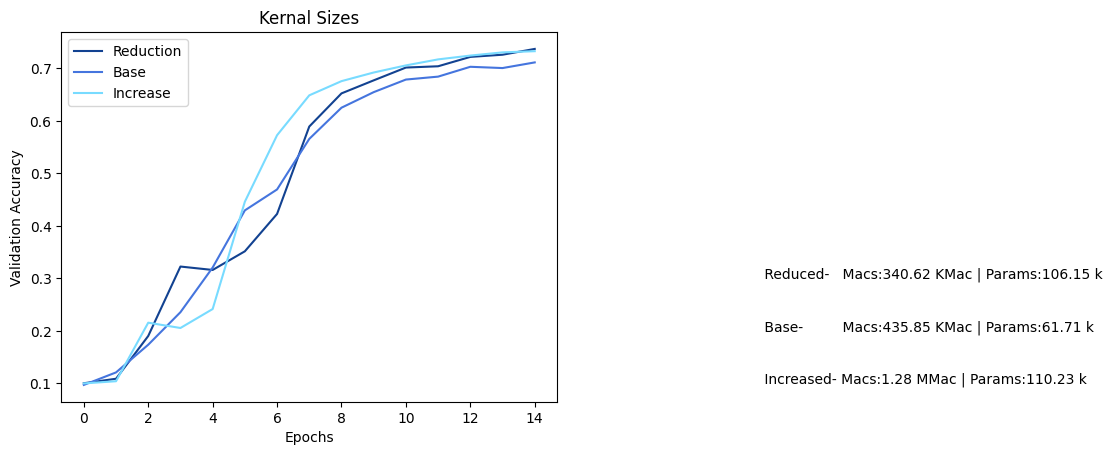

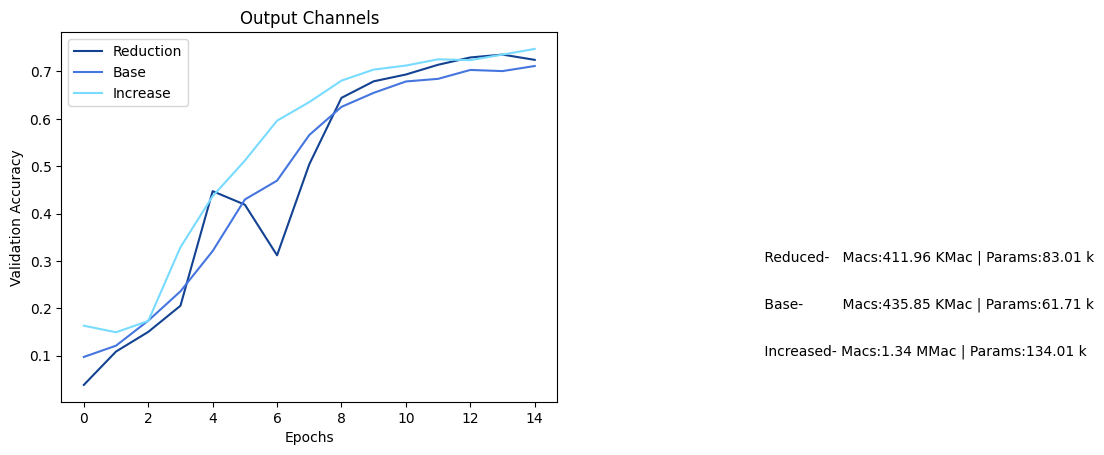

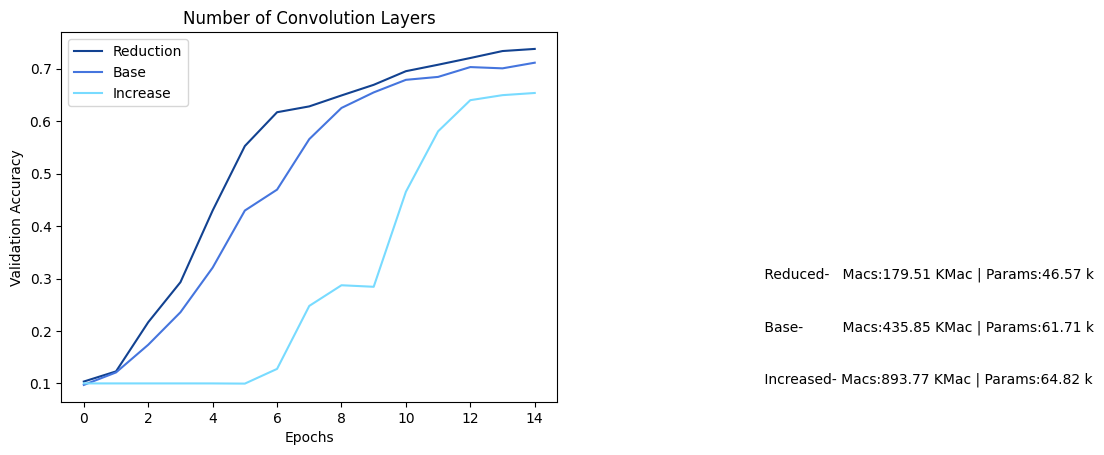

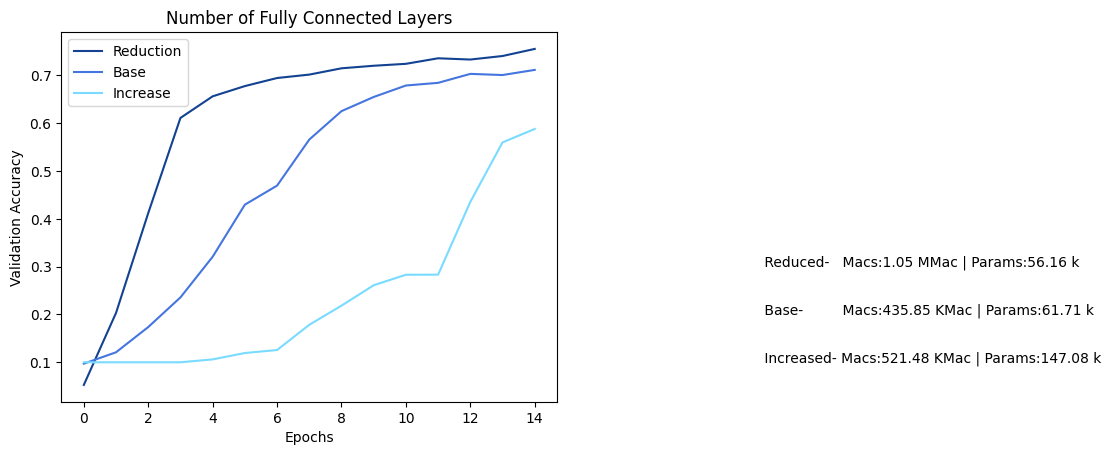

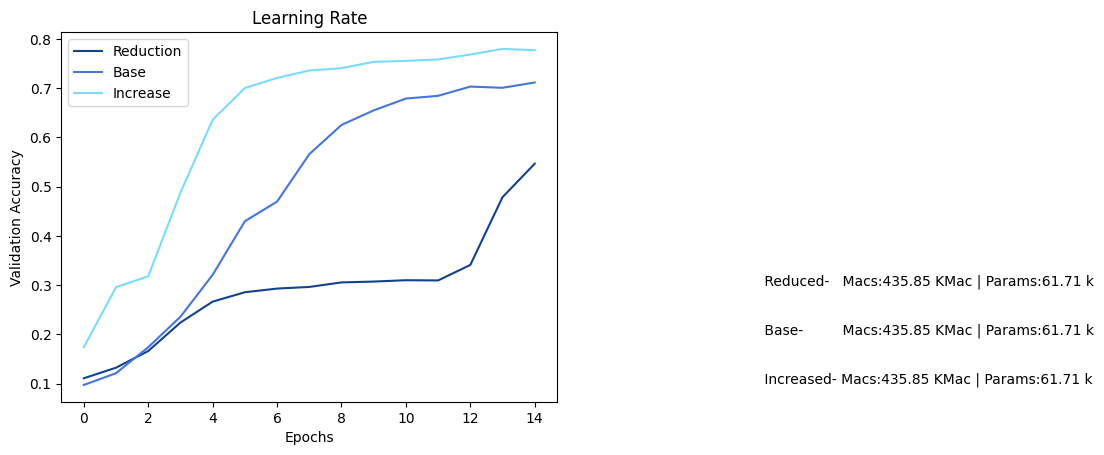

In [9]:
compare_models(ComparedModels, Titles, macs_params)

### Results of Experiments 
LeNet seems to be very well optimized. For most features the baseline did better then any reduction or increase of attrubited features studied. Only improvements to be made was an increase in the output channels, reduction of fully connected layers, and increase in the learning rate.

In [43]:
improved = LeNet()

del improved.forwardPass[-2]
del improved.forwardPass[-2]

improved.forwardPass[0] = nn.LazyConv2d(10, kernel_size=5, padding=2).to(config.device)
improved.forwardPass[3] = nn.LazyConv2d(20, kernel_size=5, padding=2).to(config.device)
improved.forwardPass[7] = nn.LazyLinear(256).to(config.device)

improved.forwardPass.insert(3, nn.Dropout2d(0.3))
improved.forwardPass.insert(8, improved.D1)

print(improved.forwardPass)

FullLayer2Trainer, mp = train_test_model(improved, config.lr*2, trainLoader, validateLoader, testLoader, config.EPOCHS, noPrint=True)

Sequential(
  (0): LazyConv2d(0, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout2d(p=0.3, inplace=False)
  (4): LazyConv2d(0, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.3, inplace=False)
  (9): LazyLinear(in_features=0, out_features=256, bias=True)
  (10): ReLU()
  (11): LazyLinear(in_features=0, out_features=10, bias=True)
)


### Problem 3: Compare the Metrics against one another (10pts)

Base Model Test: 0.7732000350952148
Improved Model Test: 0.8446000218391418


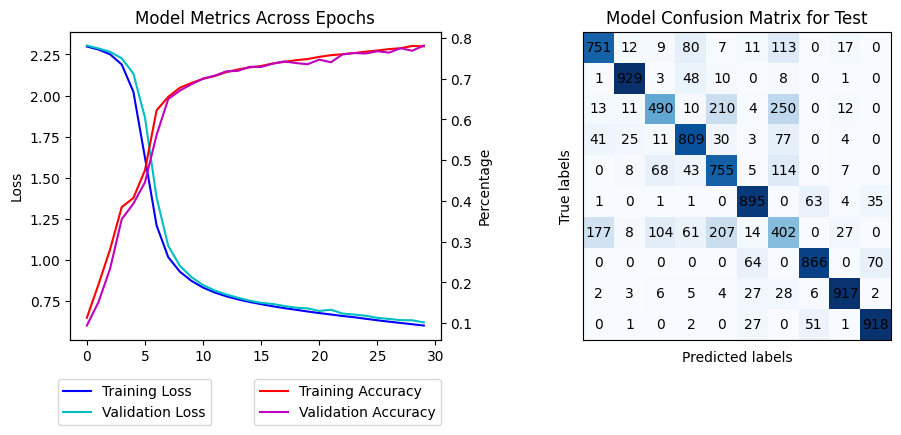

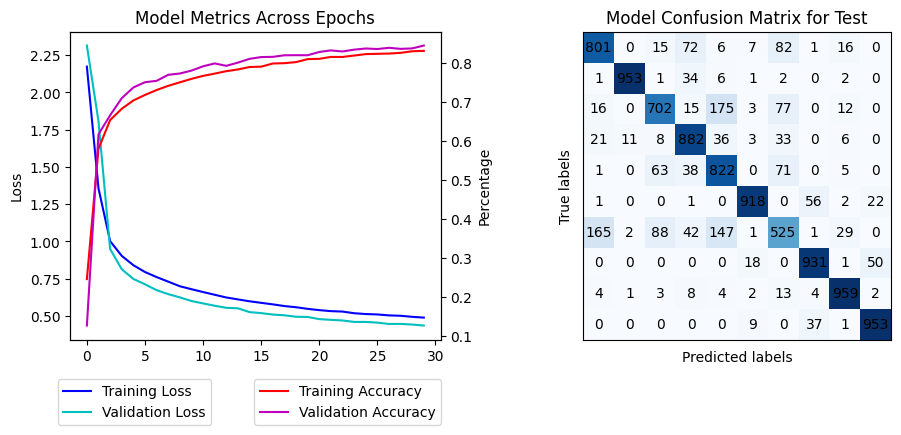

In [44]:
base = LeNet()
ComparedModels[-1], mp = train_test_model(base, config.lr, trainLoader, validateLoader, testLoader, config.EPOCHS, noPrint=True)

print("Base Model Test:", ComparedModels[-1].Metrics["Test Accuracy"])
ComparedModels[-1].Graph_Metrics()
print("Improved Model Test:", FullLayer2Trainer.Metrics["Test Accuracy"])
FullLayer2Trainer.Graph_Metrics()

### Problem 4: Simplifying the AlexNet to make the training faster (30pts)

In [27]:
class ReducedAlexNet(nn.Module):
    def __init__(self):
        super(ReducedAlexNet, self).__init__()
        
        self.net = nn.Sequential(
            nn.LazyConv2d(96, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.LazyConv2d(256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.LazyConv2d(384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            
            nn.LazyConv2d(384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.LazyLinear(2048),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.LazyLinear(1024),
            nn.ReLU(),
            nn.LazyLinear(10),
        )
    
    def forward(self, x):
        return self.net(x)

Alex Model Test: 0.885200023651123
Macs:237.3 MMac | Params:7.92 M


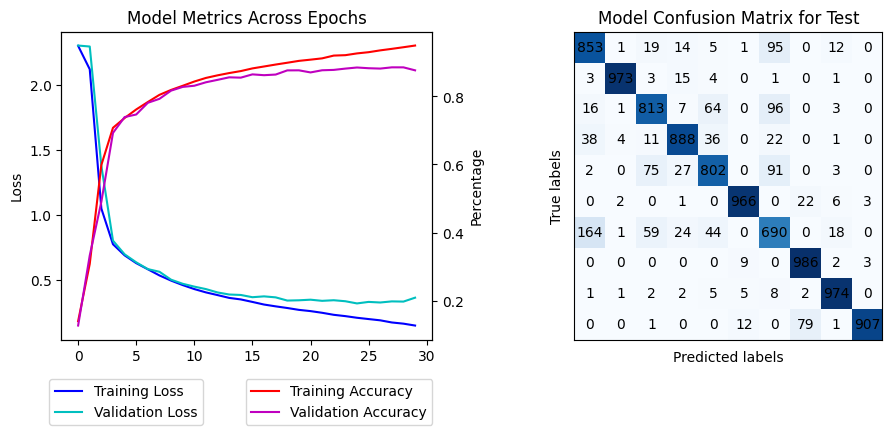

In [52]:
Alex = ReducedAlexNet()

AlexTrainer, mp = train_test_model(Alex, config.lr, trainLoader, validateLoader, testLoader, config.EPOCHS, noPrint=True)
print("Alex Model Test:", AlexTrainer.Metrics["Test Accuracy"])
print(f"Macs:{mp[0]} | Params:{mp[1]}")
AlexTrainer.Graph_Metrics()

### Problem 5: Design a more accurate and more efficent network than AlexNet (20pts Bonus)

In [15]:
def vgg_block(num_convs, out_channels, stride):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.LazyBatchNorm2d())
        layers.append(nn.ReLU())

    layers.append(nn.MaxPool2d(kernel_size=2, stride=stride))

    return nn.Sequential(*layers)

class VGG(nn.Module):
    def __init__(self, arch, num_class=10):
        super(VGG, self).__init__()
        conv_blks = []
        
        for num_convs, out_channels, stride in arch:
            conv_blks.append(vgg_block(num_convs, out_channels, stride))
            
        self.net = nn.Sequential(
            *conv_blks, 
            
            nn.Flatten(),
            nn.LazyLinear(728), nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.LazyLinear(512), nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.LazyLinear(num_class),
        )
        
    def forward(self, x):
        return self.net(x)

VGG Model Test: 0.9036999940872192
Macs:54.46 MMac | Params:7.18 M


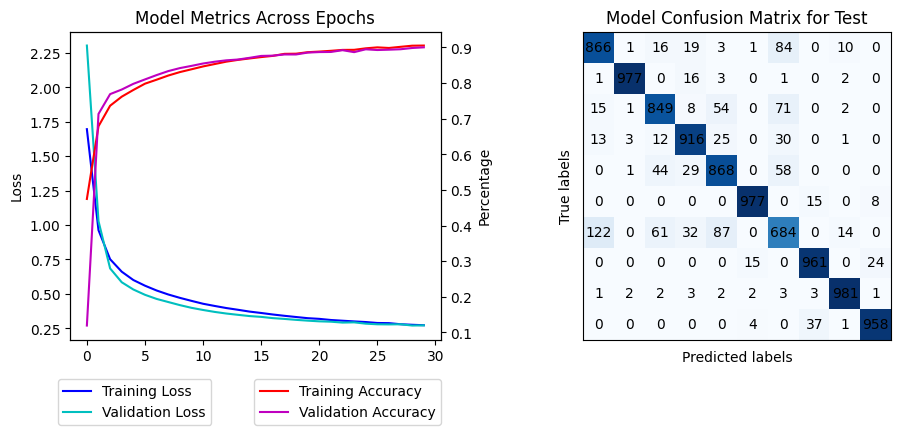

In [48]:
arch = [(1, 32, 1), (2, 64, 2), (1, 64, 1)]
vgg_net = VGG(arch)

VggTrainer, mp = train_test_model(vgg_net, config.lr, trainLoader, validateLoader, testLoader, config.EPOCHS, noPrint=True)
print("VGG Model Test:", VggTrainer.Metrics["Test Accuracy"])
print(f"Macs:{mp[0]} | Params:{mp[1]}")
VggTrainer.Graph_Metrics()

### Final Results:
Base Model Test: 0.7732

Improved Model Test: 0.8446

Alex Model Test: 0.8852
    
    Macs:237.3 MMac | Params:7.92 M

VGG Model Test: 0.9036
    
    Macs:54.46 MMac | Params:7.18 M